In [1]:
import os
os.environ['PYTHONHASHSEED'] = str(42)

import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### Load & Prepare Dataset (Cats vs Dogs)

In [2]:
splits = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

(train_examples, val_examples, test_examples), info = tfds.load(
    "cats_vs_dogs",
    with_info=True,
    as_supervised=True,
    split=splits
)

num_classes = info.features["label"].num_classes
print("Classes:", num_classes)

/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]2025-12-01 16:18:57.007541: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-12-01 16:18:57.007635: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-01 16:18:57.007647: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-01 16:18:57.007834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-01 16:18:57.008041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corru

Dataset cats_vs_dogs downloaded and prepared to /Users/zankhanamehta/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Classes: 2


### Preprocessing + Data Augmentation

In [3]:
IMG_SIZE = (160, 160)   # MobileNet default size
BATCH_SIZE = 32

# Augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomRotation(0.1)
])

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_batches = (
    train_examples.shuffle(2000)
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(1)
)

val_batches = val_examples.map(preprocess).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(preprocess).batch(1)


### Teacher Model (MobileNetV2 Fine-Tuned)

In [4]:
def create_teacher_model():
    base = keras.applications.MobileNetV2(
        input_shape=IMG_SIZE + (3,),
        include_top=False,
        weights="imagenet"
    )
    
    base.trainable = False  # freeze backbone

    model = keras.Sequential([
        data_augmentation,
        base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(2)  # logits
    ])
    return model

teacher = create_teacher_model()
teacher.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

### Student Model (Lightweight CNN)

In [5]:
def create_student_model():
    model = keras.Sequential([
        keras.layers.Conv2D(16, 3, activation="relu", input_shape=IMG_SIZE + (3,)),
        keras.layers.MaxPool2D(),
        
        keras.layers.Conv2D(32, 3, activation="relu"),
        keras.layers.MaxPool2D(),
        
        keras.layers.Conv2D(64, 3, activation="relu"),
        keras.layers.GlobalAveragePooling2D(),
        
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(2)  # logits
    ])
    return model

student = create_student_model()
student.summary()


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,874 (108.88 KB)

 Trainable params: 27,874 (108.88 KB)

 Non-trainable params: 0 (0.00 B)

### Train Teacher Model

In [ ]:
teacher.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

teacher_history = teacher.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches
)


Epoch 1/5


2025-12-01 16:21:28.639783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


582/582 ━━━━━━━━━━━━━━━━━━━━ 61s 95ms/step - accuracy: 0.9303 - loss: 0.1996 - val_accuracy: 0.9768 - val_loss: 0.0669
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 54s 91ms/step - accuracy: 0.9415 - loss: 0.1543 - val_accuracy: 0.9764 - val_loss: 0.0653
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 60s 102ms/step - accuracy: 0.9434 - loss: 0.1423 - val_accuracy: 0.9746 - val_loss: 0.0688
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 95ms/step - accuracy: 0.9460 - loss: 0.1441 - val_accuracy: 0.9764 - val_loss: 0.0632
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 57s 97ms/step - accuracy: 0.9460 - loss: 0.1390 - val_accuracy: 0.9725 - val_loss: 0.0706


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=teacher_mobilenet.

In [9]:
teacher.save("teacher_mobilenet.h5")

### Build Distiller Class

In [10]:
class Distiller(keras.Model):

    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, student_loss_fn,
                distillation_loss_fn, metrics,
                temperature=4, alpha=0.2):
        
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature
        self.alpha = alpha

    def train_step(self, data):
        x, y = data

        # Teacher predictions (not trainable)
        teacher_logits = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_logits = self.student(x, training=True)

            # Standard supervised loss
            student_loss = self.student_loss_fn(y, student_logits)

            # Softened teacher predictions
            teacher_soft = tf.nn.softmax(teacher_logits / self.temperature)
            student_soft = tf.nn.softmax(student_logits / self.temperature)

            distill_loss = self.distillation_loss_fn(teacher_soft, student_soft)

            # Weighted combination
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        grads = tape.gradient(loss, self.student.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_weights))

        self.compiled_metrics.update_state(y, student_logits)

        return {
            "loss": loss,
            "student_loss": student_loss,
            "distill_loss": distill_loss,
            **{m.name: m.result() for m in self.metrics}
        }

    def test_step(self, data):
        x, y = data
        logits = self.student(x, training=False)
        loss = self.student_loss_fn(y, logits)

        self.compiled_metrics.update_state(y, logits)
        return {"loss": loss, **{m.name: m.result() for m in self.metrics}}


### Train Student from Scratch (Baseline)

In [11]:
student_scratch = create_student_model()
student_scratch.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

scratch_history = student_scratch.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches
)


Epoch 1/5


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 24s 34ms/step - accuracy: 0.5836 - loss: 0.6650 - val_accuracy: 0.6225 - val_loss: 0.6410
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6113 - loss: 0.6472 - val_accuracy: 0.6105 - val_loss: 0.6789
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6056 - loss: 0.6603 - val_accuracy: 0.6174 - val_loss: 0.6442
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6278 - loss: 0.6372 - val_accuracy: 0.5821 - val_loss: 0.6644
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6616 - loss: 0.6140 - val_accuracy: 0.6853 - val_loss: 0.5955


### Knowledge Distillation Training

In [12]:
distiller = Distiller(student=student, teacher=teacher)

distiller.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    temperature=4,
    alpha=0.2
)

distillation_history = distiller.fit(
    train_batches,
    epochs=5,
    validation_data=val_batches
)


Epoch 1/5


/opt/anaconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:670: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


582/582 ━━━━━━━━━━━━━━━━━━━━ 56s 87ms/step - sparse_categorical_accuracy: 0.6397 - distill_loss: 0.1689 - loss: -0.0418 - student_loss: 0.6807 - val_loss: -0.0729
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 94s 161ms/step - sparse_categorical_accuracy: 0.6827 - distill_loss: 0.3076 - loss: -0.0517 - student_loss: 0.9050 - val_loss: -0.0944
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 116s 197ms/step - sparse_categorical_accuracy: 0.5378 - distill_loss: 0.2822 - loss: -0.9806 - student_loss: 0.4558 - val_loss: -1.3238
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - sparse_categorical_accuracy: 0.5744 - distill_loss: 0.2614 - loss: 0.6342 - student_loss: 0.6884 - val_loss: 0.8015
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 85s 144ms/step - sparse_categorical_accuracy: 0.6466 - distill_loss: 0.2751 - loss: 0.3996 - student_loss: 0.6526 - val_loss: 0.2348


### Evaluate Teacher vs Students

In [15]:
teacher_acc = teacher.evaluate(test_batches, return_dict=True)["accuracy"]
scratch_acc = student_scratch.evaluate(test_batches, return_dict=True)["accuracy"]

distill_results = distiller.evaluate(test_batches, return_dict=True)
print("\nReturned keys:", distill_results.keys())
print("compile_metrics:", distill_results["compile_metrics"])

# Extract accuracy from compile_metrics
if isinstance(distill_results["compile_metrics"], dict):
    distill_acc = list(distill_results["compile_metrics"].values())[0]
else:
    distill_acc = distill_results["compile_metrics"]

print(f"\nTeacher Accuracy: {teacher_acc:.3f}")
print(f"Student Scratch Accuracy: {scratch_acc:.3f}")
print(f"Distilled Student Accuracy: {distill_acc:.3f}")


2326/2326 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.9742 - loss: 0.0677
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.6892 - loss: 0.5908
2326/2326 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - sparse_categorical_accuracy: 0.6354 - loss: 0.2379

Returned keys: dict_keys(['loss', 'compile_metrics'])
compile_metrics: {'sparse_categorical_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6354256>}

Teacher Accuracy: 0.974
Student Scratch Accuracy: 0.689
Distilled Student Accuracy: 0.635


### Plot Training Curves

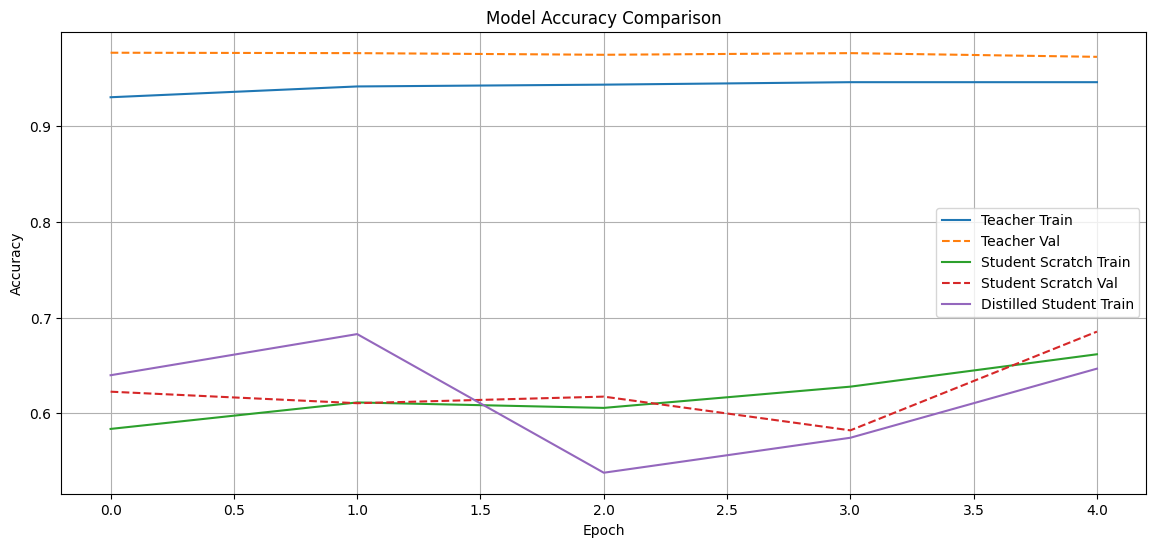

In [17]:
def plot_history(histories, names):
    plt.figure(figsize=(14,6))

    for hist, name in zip(histories, names):
        keys = hist.history.keys()

        # Detect training accuracy key
        if "accuracy" in keys:
            train_acc = hist.history["accuracy"]
        elif "sparse_categorical_accuracy" in keys:
            train_acc = hist.history["sparse_categorical_accuracy"]
        else:
            continue

        # Detect validation accuracy key
        if "val_accuracy" in keys:
            val_acc = hist.history["val_accuracy"]
        elif "val_sparse_categorical_accuracy" in keys:
            val_acc = hist.history["val_sparse_categorical_accuracy"]
        else:
            val_acc = None

        # Plot training accuracy
        plt.plot(train_acc, label=f"{name} Train")

        # Plot validation accuracy
        if val_acc is not None:
            plt.plot(val_acc, linestyle="--", label=f"{name} Val")

    plt.title("Model Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(
    [teacher_history, scratch_history, distillation_history],
    ["Teacher", "Student Scratch", "Distilled Student"]
)

The teacher model maintains the highest and most stable accuracy across all epochs, as expected from a larger pretrained network.

The student trained from scratch shows a steady rise in training accuracy but fluctuates in validation accuracy, indicating overfitting.

The distilled student learns more smoothly and stays more regularized, showing lower training accuracy but more stable generalization compared to the scratch student.

Overall, knowledge distillation provides a more controlled learning signal for the smaller model.